In [27]:
from CPPN import CPPN, geno_to_pheno, geno_to_pheno_structual
import random
import numpy as np
import open3d as o3d

# # for test stability, we need to make sure the network is deterministic
# # when realistcally used, we should eliminate the deterministic part
random.seed(4122)
np.random.seed(4122)

In [28]:
def calc_node_state(network, node_name, orig_size_xyz, density=5.):
    """Propagate input values through the network"""
    if network.graph.nodes[node_name]["evaluated"]:
        return network.graph.nodes[node_name]["state"]

    network.graph.nodes[node_name]["evaluated"] = True
    input_edges = network.graph.in_edges(nbunch=[node_name])
    
    flattened_size = network.num_points
    new_state = np.zeros(flattened_size)

    for edge in input_edges:
        node1, node2 = edge
        ### recursively evaluate the input node, if it hasn't been evaluated already
        ### at first, all the nodes are un-evaluated except the input nodes, i.e., 'x', 'y', 'z', 'd', 'bias'
        new_state += calc_node_state(network, node1, orig_size_xyz, density) * network.graph.edges[node1, node2]["weight"]

    network.graph.nodes[node_name]["state"] = new_state

    return network.graph.nodes[node_name]["function"](new_state)

In [29]:
cppn = CPPN(output_node_names=["out"])
shape = (1, 1, 1)
density = 10
cppn.set_input_node_states(shape, density, mode="structured")
output_state = calc_node_state(cppn, "out", shape, density)
pointcloud = cppn.pointcloud

In [30]:
output_state[:5]

array([ 0.41522463,  0.25808997,  0.11201027, -0.01481289, -0.11697276])

In [31]:
split_parts = geno_to_pheno_structual(pointcloud, cppn.num_geos, cppn.num_mats, output_state, [0], border_width=0.05, inside_sparsity=1)

0
1


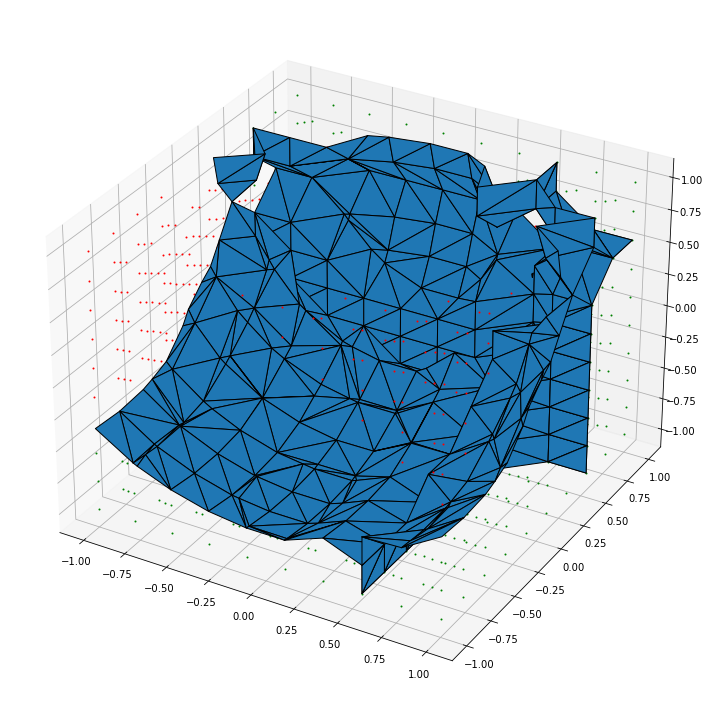

In [32]:
"""
A3D Visualize according to splits
"""
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']
for i, points in enumerate(split_parts["inside"]):
    print(i)
    for t in points:
        ax.scatter(t[0], t[1], t[2], c=colors[i], marker='o', s=1)

for borders in split_parts["border"]:
    verts, faces, normals, values = borders
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)

plt.tight_layout()
plt.show()

In [33]:
# # o3d visualization
color_parts = [[1, 0, 0], [0, 1, 0], [30/255.,144/255.,1], [1, 1, 1]]
# material_color_parts = [0.5, 0.5, 0.5]
material_color_parts = [1, 1, 1]
clouds = []
for i, split_part in enumerate(split_parts["inside"]):
    print("material ", str(i+1), ": ", len(split_part))
    cloud = o3d.geometry.PointCloud()
    cloud.points = o3d.utility.Vector3dVector(split_part[:, :3])
    colors = np.zeros([split_part.shape[0], 3])
    colors[:, :] = color_parts[i]
    colors[split_part[:, -1] == 1, :] = material_color_parts # material points
    cloud.colors = o3d.utility.Vector3dVector(colors)
    clouds.append(cloud)
border_points = split_parts["border"][0][0]
cloud = o3d.geometry.PointCloud()
colors = np.zeros([border_points.shape[0], 3])
colors[:, :] = [0, 0, 1]
cloud.points = o3d.utility.Vector3dVector(border_points)
cloud.colors = o3d.utility.Vector3dVector(colors)
clouds.append(cloud)
o3d.visualization.draw_geometries(clouds)

material  1 :  942
material  2 :  618
